# AWS and GCP Text Analysis - Yelp Reviews

This notebook aims at exploring AWS and GCP to deal with ‘Big Data’ and another approach to text analysis.

## Preprocessing Packages and Data

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import warnings

import string
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

import boto3
import os
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

In [3]:
df_original = pd.read_csv('Yelp.csv')
df_original.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


Since we want to analyse sentiment of customers' feedback, we need to remove all columns related to sentiment and other unuseful ones

In [4]:
warnings.filterwarnings('ignore')
df = df_original[['stars', 'text']]
df.rename(columns={'stars': 'Stars', 'text': 'Comment'}, inplace=True)
df.head()

,Stars,Comment
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...


## AWS Text Analysis

### Test AWS Credentials

In [5]:
!mkdir -p ~/.aws &&\
  cat /Users/zhenyufan/Downloads/credentials.txt > ~/.aws/credentials

!cd ~/.aws &&\
  cat /Users/zhenyufan/Downloads/config.txt > ~/.aws/config

In [6]:
comprehend = boto3.client(service_name='comprehend', region_name="us-east-1")
text = "It is raining today in Seattle"
res = comprehend.detect_sentiment(Text=text, LanguageCode='en')["Sentiment"]
res

'NEUTRAL'

### Apply to Yelp's Comment

In [7]:
def create_sentiment(row):
    """Uses AWS Comprehend to Create Sentiments on a DataFrame"""

    try: 
        comprehend = boto3.client(service_name='comprehend', region_name="us-east-1")
        payload = comprehend.detect_sentiment(Text=row, LanguageCode='en')  
        sentiment = payload['Sentiment']
    except Exception:
        print("Size exceeded:  Fail")
        return None
    return sentiment

In [8]:
df['Sentiment'] = df['Comment'].apply(create_sentiment)
df.head()

,Stars,Comment,Sentiment
0,5,My wife took me here on my birthday for breakf...,POSITIVE
1,5,I have no idea why some people give bad review...,POSITIVE
2,4,love the gyro plate. Rice is so good and I als...,POSITIVE
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",POSITIVE
4,5,General Manager Scott Petello is a good egg!!!...,POSITIVE


### Word Clouds of Positive and Negative Comments

In [32]:
def remove_punc_stopword(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    remove_punc = [word for word in text if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word.lower() for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

In [34]:
yelp_sentiment_text = df.copy()
yelp_sentiment_text['Comment'] = yelp_sentiment_text['Comment'].apply(remove_punc_stopword)

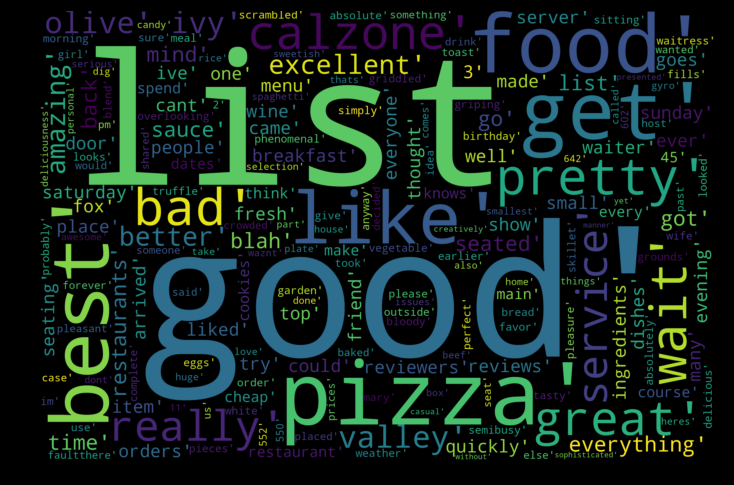

In [39]:
yelp_positive_text = yelp_sentiment_text[yelp_sentiment_text['Sentiment'] == 'POSITIVE']['Comment'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(yelp_positive_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

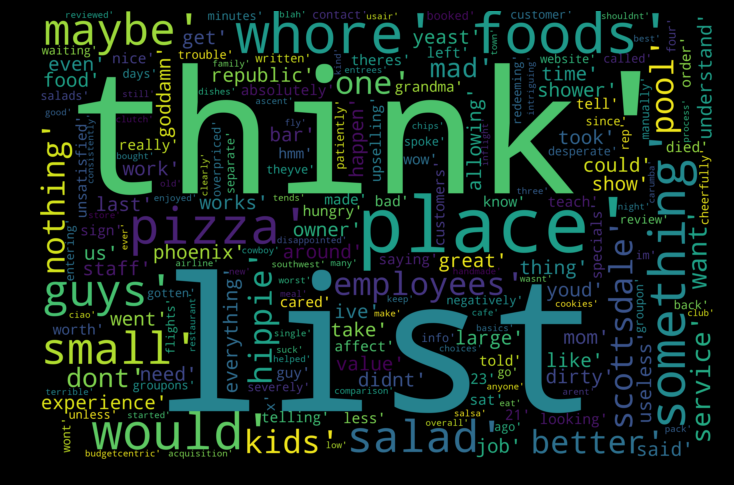

In [41]:
yelp_negtive_text = yelp_sentiment_text[yelp_sentiment_text['Sentiment'] == 'NEGATIVE']['Comment'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(yelp_negtive_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

### Bar Chart of Sentiment and Stars

In [115]:
# Positive Stars Count
yelp_positive_stars = yelp_sentiment_text[yelp_sentiment_text['Sentiment'] == 'POSITIVE']['Stars']
yelp_positive_stars = pd.DataFrame(yelp_positive_stars)

sequence = np.linspace(1, 5, num=5, endpoint=True)

positive_stars_count = []
for i in sequence:
    count = yelp_positive_stars[yelp_positive_stars['Stars'] == i]['Stars'].count()
    positive_stars_count.append(count)
print(positive_stars_count)

# Negative Stars Count
yelp_negative_stars = yelp_sentiment_text[yelp_sentiment_text['Sentiment'] == 'NEGATIVE']['Stars']
yelp_negative_stars = pd.DataFrame(yelp_negative_stars)

negative_stars_count = []
for i in sequence:
    count = yelp_negative_stars[yelp_negative_stars['Stars'] == i]['Stars'].count()
    negative_stars_count.append(count)
print(negative_stars_count)

[79, 260, 1002, 3336, 3224]
[608, 541, 250, 69, 32]


In [114]:
trace0 = go.Bar(
    x=['1', '2', '3', '4', '5'],
    y=positive_stars_count,
    name='Positive'
)
trace1 = go.Bar(
    x=['1', '2', '3', '4', '5'],
    y=negative_stars_count,
    name='Negative'
)

data = [trace0, trace1]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Those ‘POSITIVE’ restaurants are high-stars ones and ‘NEGATIVE’ are low-stars ones, which means AWS sentiment analysis is accurate enouth.

## GCP Text Analysis

### Test GCP Credentials

In [10]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/zhenyufan/Downloads/My Project-ca5496ca24e3.json"

In [54]:
text = 'I am delighted'
document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)

# Detects the sentiment of the text
sentiment = client.analyze_sentiment(document=document).document_sentiment

In [57]:
print(sentiment.score)

0.8999999761581421


### Apply to Yelp Reviews

In [58]:
def create_sentiment_score(row):
    """Uses GCP to Create Sentiments on a DataFrame"""

    try: 
        document = types.Document(content=row, type=enums.Document.Type.PLAIN_TEXT)  
        sentiment = client.analyze_sentiment(document=document).document_sentiment
        sentiment_score = sentiment.score
    except Exception:
        print("Size exceeded:  Fail")
        return None
    return sentiment_score

In [59]:
df['Sentiment Score'] = df['Comment'].apply(create_sentiment_score)
df.head()

,Stars,Comment,Sentiment,Sentiment Score
0,5,My wife took me here on my birthday for breakf...,POSITIVE,0.6
1,5,I have no idea why some people give bad review...,POSITIVE,0.2
2,4,love the gyro plate. Rice is so good and I als...,POSITIVE,0.8
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",POSITIVE,0.3
4,5,General Manager Scott Petello is a good egg!!!...,POSITIVE,0.5


### Word Clouds of Positive and Negtive

In [60]:
yelp_score_text = df.copy()
yelp_score_text['Comment'] = yelp_score_text['Comment'].apply(remove_punc_stopword)

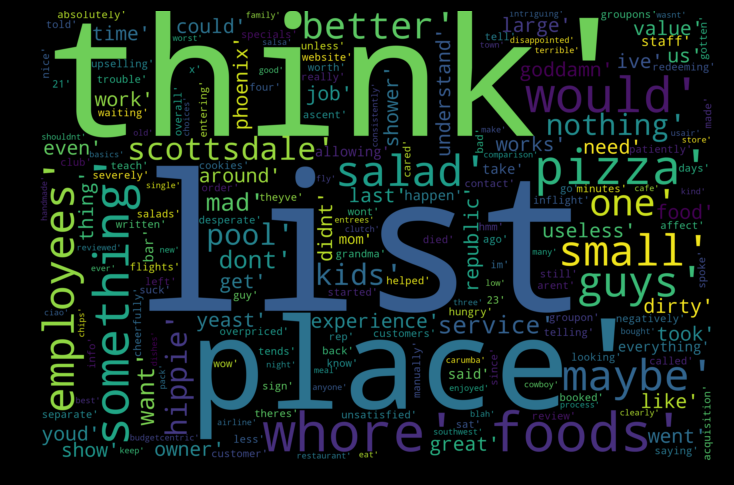

In [61]:
yelp_positive_score_text = yelp_score_text[yelp_score_text['Sentiment Score'] > 0.7]['Comment']
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(yelp_negtive_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

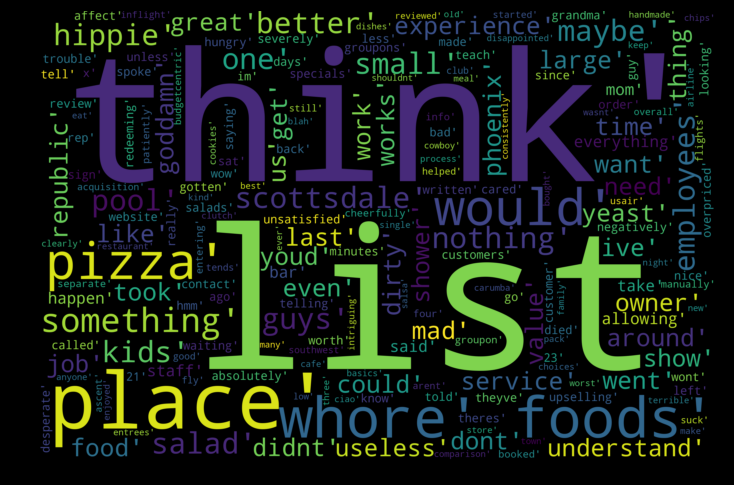

In [62]:
yelp_negtive_score_text = yelp_score_text[yelp_score_text['Sentiment Score'] < 0.3]['Comment']
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(yelp_negtive_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

### Bar Chart of Sentiment and Stars

In [119]:
# Positive Stars Count
yelp_positive_score_stars = yelp_score_text[yelp_score_text['Sentiment Score'] > 0.7]['Stars']
yelp_positive_score_stars = pd.DataFrame(yelp_positive_score_stars)

sequence = np.linspace(1, 5, num=5, endpoint=True)

positive_score_stars_count = []
for i in sequence:
    count = yelp_positive_score_stars[yelp_positive_score_stars['Stars'] == i]['Stars'].count()
    positive_score_stars_count.append(count)
print(positive_score_stars_count)

# Negative Stars Count
yelp_negative_score_stars = yelp_score_text[yelp_score_text['Sentiment Score'] < 0.3]['Stars']
yelp_negative_score_stars = pd.DataFrame(yelp_negative_score_stars)

negative_score_stars_count = []
for i in sequence:
    count = yelp_negative_score_stars[yelp_negative_score_stars['Stars'] == i]['Stars'].count()
    negative_score_stars_count.append(count)
print(negative_score_stars_count)

[0, 1, 49, 419, 561]
[746, 900, 1004, 887, 534]


In [120]:
trace0 = go.Bar(
    x=['1', '2', '3', '4', '5'],
    y=positive_score_stars_count,
    name='Positive'
)
trace1 = go.Bar(
    x=['1', '2', '3', '4', '5'],
    y=negative_score_stars_count,
    name='Negative'
)

data = [trace0, trace1]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Those ‘POSITIVE’ restaurants are high-stars ones and ‘NEGATIVE’ are low-stars ones, which means GCP sentiment analysis is accurate enouth.

## Conclusion

From technical aspects, AWS and GCP Text Analysis are two possible ways to conduct ‘Big Data’ text analysis. They are efficient, accurate, and inexpensive, which will advance our team’s and company’s performance. What’s more, sentiment analysis can provide powerful support for restaurants’ improvements and Yelp’s development.

In practice, there is no doubt that food and service mean everything for restaurants. With better food and service, restaurants will definitely get positive feedback and attract more customers. What’s more, the list or menu is another essential factor and may be easily ignored by restaurants. They should make their menus more readable and acceptable with clear structure and fair price.
